<a href="https://colab.research.google.com/github/Kussil/Financial_Sentiment_LLM/blob/main/04_Stock_Modeling/Stock_Modeling_FinBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Modeling using FinBERT Sentiments

In [18]:
#install dependencies
!pip install -q ipympl

In [19]:
# import libraries
import os
from google.colab import userdata
from google.colab import output
import pandas as pd
import yfinance as yf
import textwrap
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
output.enable_custom_widget_manager()

In [20]:
#Delete repo clone if needed
#!rm -rf /content/CVX_Rice_project/

In [21]:
# Import github token with google secrets thingy and clone git repository
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone https://{GITHUB_TOKEN}@github.com/Kussil/Financial_Sentiment_LLM.git

Cloning into 'Financial_Sentiment_LLM'...
remote: Enumerating objects: 1980, done.
remote: Counting objects: 100% (385/385), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 1980 (delta 229), reused 317 (delta 184), pack-reused 1595
Receiving objects: 100% (1980/1980), 366.35 MiB | 8.37 MiB/s, done.
Resolving deltas: 100% (1312/1312), done.
Updating files: 100% (1124/1124), done.


In [22]:
# Read in outputs from FINBERT Sentiment Analysis
df_chunk = pd.read_csv('/content/Financial_Sentiment_LLM/03_Sentiment_Analysis/sentiment_chunkdata.csv')
df_chunk = df_chunk.fillna('')
df = df_chunk.groupby(['Article Index','Ticker','Source','Date','Article Headline','URL'])[['Neutral', 'Positive', 'Negative']].mean().reset_index()

In [23]:
df

,Article Index,Ticker,Source,Date,Article Headline,URL,Neutral,Positive,Negative
0,0,MRO,Investment Research,2024-05-16,Marathon Oil Corporation,,0.143564,0.413686,0.442750
1,1,EOG,Investment Research,2024-05-14,"EOG Resources, Inc.",,0.164021,0.042301,0.793678
2,2,EOG,Investment Research,2024-05-11,"EOG Resources, Inc.",,0.138396,0.089975,0.771630
3,3,DVN,Investment Research,2024-05-11,Devon Energy Corporation,,0.047985,0.468556,0.483459
4,4,COP,Investment Research,2024-05-07,ConocoPhillips,,0.266492,0.181206,0.552303
...,...,...,...,...,...,...,...,...,...
8599,8599,PSX,ProQuest,2019-06-12,"As the Price of Gas Tumbles, Even California I...",https://www.proquest.com/newspapers/as-price-g...,0.024151,0.501878,0.473971
8600,8600,PSX,ProQuest,2019-06-10,"Phillips 66, Plains plan pipeline system",https://www.proquest.com/newspapers/phillips-6...,0.097232,0.011336,0.891432
8601,8601,PSX,ProQuest,2019-06-07,Autonomous robot inspects in-service diesel st...,https://www.proquest.com/newspapers/autonomous...,0.495722,0.008984,0.495294
8602,8602,PSX,ProQuest,2019-06-03,United States/Mexico: Report: Trump's Tariff o...,https://www.proquest.com/newspapers/united-sta...,0.098247,0.857687,0.044066


In [24]:
#Remove non stock Ticker values
df.drop(df[df['Ticker'] == 'BP.'].index, inplace=True)
df.drop(df[df['Ticker'] == 'Concho Resources Inc.'].index, inplace=True)
df.drop(df[df['Ticker'] == 'PDCE'].index, inplace=True)
df.drop(df[df['Ticker'] == 'TTL'].index, inplace=True)
df.drop(df[df['Ticker'] == 'CXO'].index, inplace=True)
ticker_list = df['Ticker'].unique().tolist()
ticker_list

['MRO',
 'EOG',
 'DVN',
 'COP',
 'PXD',
 'CVX',
 'MPC',
 'HES',
 'PSX',
 'XOM',
 'SHEL',
 'BP',
 'OXY',
 'VLO',
 'TTE',
 'EQNR']

In [25]:
#Identify minimum article date for stock price download
min_date = df['Date'].min()
min_date

'2019-02-01'

In [26]:
#Pull YahooFinance stock data to get Returns (ret)
ticker = ticker_list#ticker_list
price = yf.download(ticker, start=min_date)["Adj Close"]
ret = price.pct_change().dropna()
ret.name = "ret"
ret.describe()

[*********************100%%**********************]  16 of 16 completed


Ticker,BP,COP,CVX,DVN,EOG,EQNR,HES,MPC,MRO,OXY,PSX,PXD,SHEL,TTE,VLO,XOM
count,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000
mean,0.000372,0.000857,0.000607,0.001279,0.000755,0.000655,0.001233,0.001288,0.001135,0.000803,0.000776,0.001089,0.000509,0.000610,0.001033,0.000686
std,0.023009,0.027305,0.021722,0.036456,0.029488,0.023994,0.030487,0.029260,0.036206,0.038555,0.025979,0.028983,0.022666,0.021132,0.029710,0.021008
min,-0.191040,-0.248401,-0.221248,-0.373972,-0.320072,-0.210562,-0.336685,-0.270089,-0.468521,-0.520138,-0.158658,-0.369197,-0.171722,-0.178208,-0.192209,-0.122248
25%,-0.010083,-0.011922,-0.008515,-0.016692,-0.014352,-0.011739,-0.014416,-0.012239,-0.017015,-0.015161,-0.010682,-0.013242,-0.009789,-0.009760,-0.012719,-0.010426
50%,0.000000,-0.000154,0.000739,0.000466,-0.000180,0.000000,0.001084,0.001800,0.000441,-0.000161,0.000681,0.000049,0.000480,0.001354,0.000372,0.000262
75%,0.009825,0.014043,0.009500,0.017617,0.014470,0.013563,0.015107,0.014947,0.017428,0.015107,0.013725,0.014066,0.010660,0.010430,0.015570,0.011258
max,0.216053,0.252138,0.227407,0.210721,0.165703,0.133042,0.203153,0.206285,0.232445,0.336978,0.221722,0.204344,0.196795,0.152756,0.312025,0.126868


In [45]:
# add overall article sentiment
df_sentiment = df

# get Sentiment based on max score
df_sentiment['Sentiment'] = df_sentiment[['Neutral', 'Positive', 'Negative']].idxmax(axis=1)

# aggregate by ticker and date
df_grouped = df_sentiment.groupby(['Ticker', 'Date']).agg(
    article_count=('Article Headline', 'size'),
    neutral_count=('Sentiment', lambda x: (x == 'Neutral').sum()),
    positive_count=('Sentiment', lambda x: (x == 'Positive').sum()),
    negative_count=('Sentiment', lambda x: (x == 'Negative').sum()),
    neutral_avg=('Neutral','mean'),
    positive_avg=('Positive','mean'),
    negative_avg=('Negative','mean')
).reset_index()
df_grouped['Date String'] = df_grouped['Date'].astype(str)

# reshape ret same day
ret_stack = ret.stack().reset_index()
ret_stack.columns = ['Date', 'Ticker', 'Returns']
ret_stack['Date'] = pd.to_datetime(ret_stack['Date'], format='mixed')
ret_stack['Date']= pd.to_datetime(ret_stack['Date']).dt.date
ret_stack['Date String']= ret_stack['Date'].astype(str)
ret_stack.drop(columns=['Date'], inplace=True)

# merge in returns for the day from YahooFinance
df_merged = pd.merge(df_grouped, ret_stack, on=['Ticker', 'Date String'], how='left')
df_merged.drop(columns=['Date String'], inplace=True)
df_merged = df_merged.sort_values(['Ticker', 'Date'])

# Fill NaN values with the next day's value within the same 'Ticker'
df_merged['Returns (no NaN)'] = df_merged.groupby('Ticker')['Returns'].fillna(method='bfill')
df_merged['Returns Next Day'] = df_merged.groupby('Ticker')['Returns'].shift(-1)
df_merged['Returns Next Day(no NaN)'] = df_merged.groupby('Ticker')['Returns Next Day'].fillna(method='bfill')
df_merged['Returns Next Day(no NaN)'] = df_merged['Returns Next Day(no NaN)'].fillna(df_merged['Returns (no NaN)'])
df_merged['Neu Ratio'] = df_merged['neutral_count']/df_merged['article_count']
df_merged['Pos Ratio'] = df_merged['positive_count']/df_merged['article_count']
df_merged['Neg Ratio'] = df_merged['negative_count']/df_merged['article_count']
df_merged

,Ticker,Date,article_count,neutral_count,positive_count,negative_count,neutral_avg,positive_avg,negative_avg,Returns,Returns (no NaN),Returns Next Day,Returns Next Day(no NaN),Neu Ratio,Pos Ratio,Neg Ratio
0,BP,2019-02-20,1,1,0,0,0.360758,0.294953,0.344289,0.002360,0.002360,-0.003482,-0.003482,1.0,0.0,0.0
1,BP,2019-05-06,1,0,1,0,0.037869,0.626881,0.335249,-0.003482,-0.003482,-0.009591,-0.009591,0.0,1.0,0.0
2,BP,2019-05-22,2,0,0,2,0.088732,0.208069,0.703199,-0.009591,-0.009591,-0.023618,-0.023618,0.0,0.0,1.0
3,BP,2019-05-23,1,0,0,1,0.181392,0.017759,0.800849,-0.023618,-0.023618,-0.007555,-0.007555,0.0,0.0,1.0
4,BP,2019-05-31,1,0,0,1,0.135504,0.025621,0.838875,-0.007555,-0.007555,0.006179,0.006179,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6354,XOM,2024-05-07,1,0,1,0,0.031351,0.580889,0.387760,-0.004968,-0.004968,0.019716,0.019716,0.0,1.0,0.0
6355,XOM,2024-05-09,1,0,0,1,0.188978,0.233985,0.577037,0.019716,0.019716,-0.004053,-0.004053,0.0,0.0,1.0
6356,XOM,2024-05-10,2,0,1,1,0.100749,0.556811,0.342440,-0.004053,-0.004053,NaN,0.015017,0.0,0.5,0.5
6357,XOM,2024-05-11,1,0,0,1,0.172089,0.253665,0.574246,NaN,0.015017,0.015017,0.015017,0.0,0.0,1.0


In [28]:
# save csv locally
df_merged.to_csv('/content/sample_data/sent_stock_data.csv', index=False)

#Copy CSV to GitHub Repository

!cp /content/sample_data/sent_stock_data.csv /content/Financial_Sentiment_LLM/04_Stock_Modeling/
#Commit and Push Changes

!git config --global user.email "bw58@rice.edu"
%cd /content/Financial_Sentiment_LLM/04_Stock_Modeling/
!git add sent_stock_data.csv
!git commit -m "Add sent_stock_data.csv"
!git push origin main

/content/Financial_Sentiment_LLM/04_Stock_Modeling
[main 2899e5b] Add sent_stock_data.csv
 1 file changed, 5383 insertions(+), 5383 deletions(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 87.78 KiB | 1.46 MiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/Kussil/Financial_Sentiment_LLM.git
   c125e16..2899e5b  main -> main


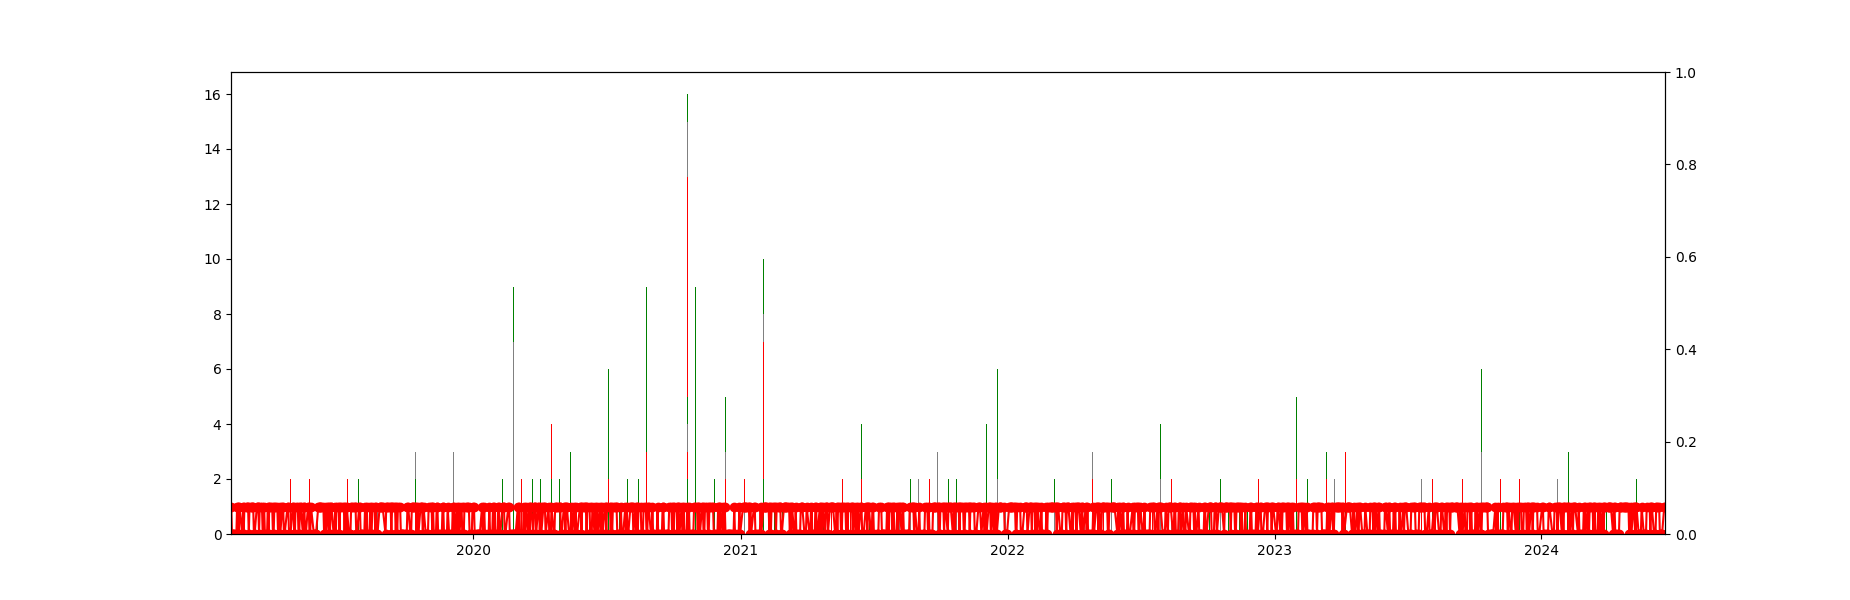

In [29]:
# Visualize Example Stock Price Movements (Up/Down) with Article Counts
%matplotlib ipympl
tz = pytz.timezone('America/New_York')

fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 6, forward=True)

tolerance = 2 # points

ret_binary = ret['CVX'].apply(lambda x: 1 if x > 0.0 else 0)

ax1.plot(ret.index, ret_binary, 'ro-', picker=tolerance)

#stacked bar
dates = df_merged['Date']
weights = {
    "Negative": df_merged['negative_count'].tolist(),
    "Neutral": df_merged['neutral_count'].tolist(),
    "Positive": df_merged['positive_count'].tolist()
}

colors = {
    "Negative": 'red',
    "Neutral": 'gray',
    "Positive": 'green'
}

ax2 = ax1.twinx()

width = 0.1
bottom = np.zeros(len(dates))

for sentiment, weight in weights.items():
  p = ax1.bar(dates, weight, width, label=sentiment, bottom=bottom, color=colors[sentiment])
  bottom += weight

ax1.set_xlim(left=ret.index.min(),right=ret.index.max())
ax2.set_xlim(left=ret.index.min(),right=ret.index.max())

def onclick(event):
    line = event.artist
    xdata, ydata = line.get_data()
    ind = event.ind
    datetime_obj  = xdata[ind][0].astype('datetime64[s]').astype(datetime)
    formatted_date = datetime_obj.strftime('%Y-%m-%d')
    print(formatted_date)
    #query = 'summarize the top news articles for chevron?'
    #top_results = 3
    #print(textwrap.fill(ask_vector_query(query, top_results, date=str(formatted_date), pinecone_index = "newsembedding3"), width=80))

#cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid = fig.canvas.mpl_connect('pick_event', onclick)

In [56]:
# prep data for modeling
df_merged_drop = df_merged.drop(['Returns','Returns Next Day', 'Returns Next Day(no NaN)'], axis=1)
df_dropna = df_merged_drop.dropna()

# Convert the 'Date' column to datetime
df_dropna['Date'] = pd.to_datetime(df_dropna['Date'])

# Define the split date
base_date = pd.to_datetime('2022-01-01')
split_date = pd.to_datetime('2024-01-01')

# Split the DataFrame
train_df = df_dropna[(df_dropna['Date'] < split_date) & (df_dropna['Date'] >= base_date)]
test_df = df_dropna[df_dropna['Date'] >= split_date]

# define input variables
X_train_df = train_df.drop(columns=['Date','Ticker','Returns (no NaN)'])
X_test_df = test_df.drop(columns=['Date','Ticker','Returns (no NaN)'])

# define target variable
y_train_df = train_df['Returns (no NaN)'].apply(lambda x: 1 if x > 0.0 else 0)
y_test_df = test_df['Returns (no NaN)'].apply(lambda x: 1 if x > 0.0 else 0)

# Split the dataset into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# If you need to separate features and labels
X_train = X_train_df
y_train = y_train_df

X_test = X_test_df
y_test = y_test_df

print(len(X_train), len(y_train), len(X_test), len(y_test))

2742 2742 464 464


<ipython-input-56-36853a949fb5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna['Date'] = pd.to_datetime(df_dropna['Date'])


In [1]:
######## Train Random Forest Model ############

# Define the parameter grid
#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'bootstrap': [True, False]
#}
param_grid = {
    'n_estimators': [300],
    'max_depth': [None],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

# Create a Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Train the classifier on the training set
grid_search.fit(X_train, y_train)

# Output the best parameters
print(grid_search.best_params_)

# Use the best estimator for predictions
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(X_train_df.columns)
print(best_model.feature_importances_)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

NameError: name 'RandomForestClassifier' is not defined

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.8}
Accuracy: 0.4956896551724138
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.46      0.51       263
           1       0.43      0.55      0.48       201

    accuracy                           0.50       464
   macro avg       0.50      0.50      0.50       464
weighted avg       0.51      0.50      0.50       464

[0.09637948 0.07447044 0.11979315 0.08075997 0.107348   0.10900158
 0.11503307 0.10660337 0.07951424 0.11109676]


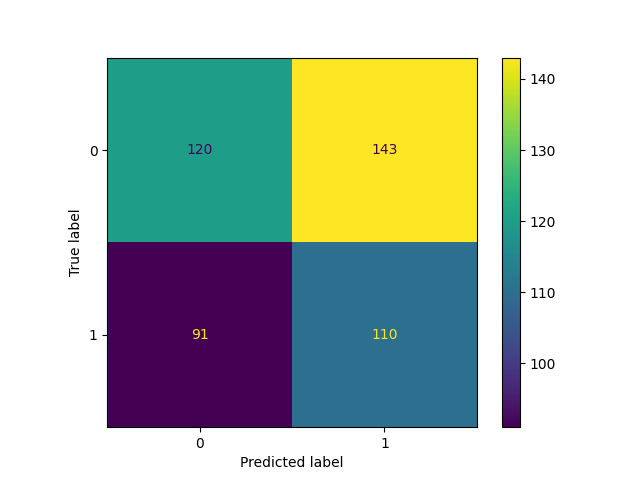

In [52]:
############# Train XGBoost Model ##############
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [3, 6, 9],
#    'learning_rate': [0.1, 0.2, 0.3],
#    'subsample': [0.8, 1.0],
#    'colsample_bytree': [0.8, 1.0],
#    'gamma': [0, 0.1, 0.2],
#    'reg_alpha': [0, 0.1, 0.5],
#    'reg_lambda': [1, 1.5, 2]
#}

param_grid = {
    'colsample_bytree': [0.8],
    'gamma': [0.1],
    'learning_rate': [0.2],
    'max_depth': [6],
    'n_estimators': [100],
    'reg_alpha': [0],
    'reg_lambda': [2],
    'subsample': [0.8]
}

# Initialize the model
XGB = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=XGB, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to find the best parameters (assuming you have training data `X_train` and `y_train`)
grid_search.fit(X_train, y_train)

# Output the best parameters
print(grid_search.best_params_)

# Use the best estimator for predictions
best_model_XGB = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model_XGB.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
#print(X.columns)
print(best_model_XGB.feature_importances_)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model_XGB, X_test, y_test)

Accuracy: 0.49888641425389757
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.49      0.50       904
           1       0.50      0.51      0.50       892

    accuracy                           0.50      1796
   macro avg       0.50      0.50      0.50      1796
weighted avg       0.50      0.50      0.50      1796



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


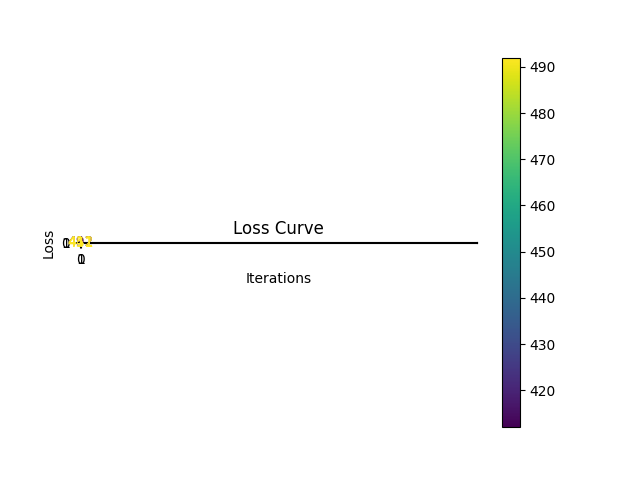

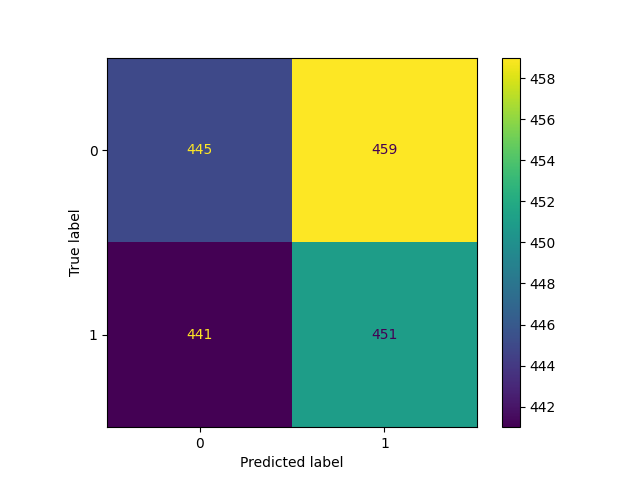

In [37]:
######## Train Simple Neural Network ##################

# Create an MLP classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(100,100),
    max_iter=1000,
    solver='adam',
    random_state=42,
    learning_rate='constant',
    learning_rate_init=0.001,
    early_stopping=False,
    tol = 1e-8,
    n_iter_no_change = 100)


# Train the model
mlp.fit(X_train, y_train)

# Predict on test data
y_pred = mlp.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the loss curve
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()


ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test)

Train Accuracy: 0.5156832638736565
Test Accuracy: 0.5183741648106904


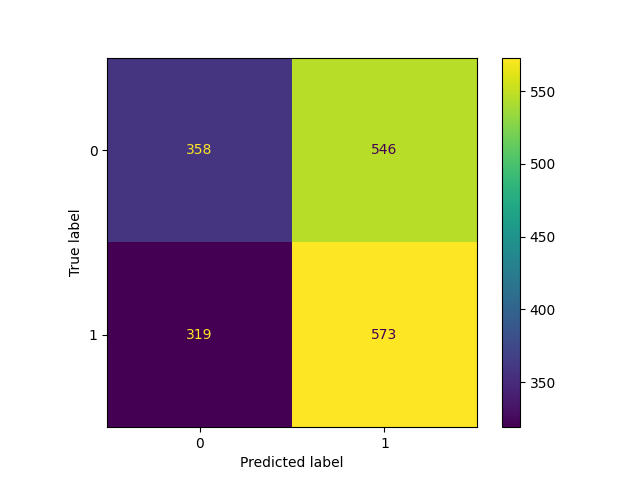

In [38]:
############# Train Support Vector Maching (SVM) #########
# Initialize lists to store training sizes and corresponding accuracies
training_sizes = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

# Loop over different training set sizes
svm = SVC(kernel='sigmoid', random_state=42)
svm.fit(X_train, y_train)

# Predict on the training and test data
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

# Calculate accuracy for the training and test data
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('Train Accuracy:',train_accuracy)
print('Test Accuracy:',test_accuracy)

ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test)